<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Change_Point_Detection/change_point_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change Point Detection

In [1]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.1 MB/s eta 0:00:00


In [2]:
# Libraries
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

# MatPlotLib style
plt.style.use('ggplot')

## 0. Signal Creation

In [3]:
# generate signal
n_samples, dim, sigma = 1000, 3, 5
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# 1D signal
d1_signal = [signal[i][0] for i in range(len(signal))]
x = list(range(len(d1_signal)))

In [4]:
# Dataset 0

lists_d0 = []
for j in range(0,4501,500):
  lists_d0.append([i for i in range(j,j+500,20)])
for lista in lists_d0:
  lista.reverse()
lists_d0.reverse()

lists_d0_nr = []
for j in range(0,5001,500):
  lists_d0_nr.append(np.repeat(j,50).tolist())
lists_d0_nr.reverse()

final_list_d0 = []
for i in range(min(len(lists_d0),len(lists_d0_nr))):
  final_list_d0 = final_list_d0 + lists_d0_nr[i] + lists_d0[i]
final_list_d0 = final_list_d0 + lists_d0_nr[-1]

In [5]:
# Dataset 1

lists_d1 = []
for j in range(11):
  lists_d1.append([2000+5*i for i in range(51)])

lists_d1_r = []
for j in range(10):
  l = [2000+5*i for i in range(0,51,2)]
  l.reverse()
  lists_d1_r.append(l)
del l

final_list_d1 = []
for i in range(min(len(lists_d1),len(lists_d1_r))):
  final_list_d1 = final_list_d1 + lists_d1[i] + lists_d1_r[i]
final_list_d1 = final_list_d1 + lists_d1[-1]

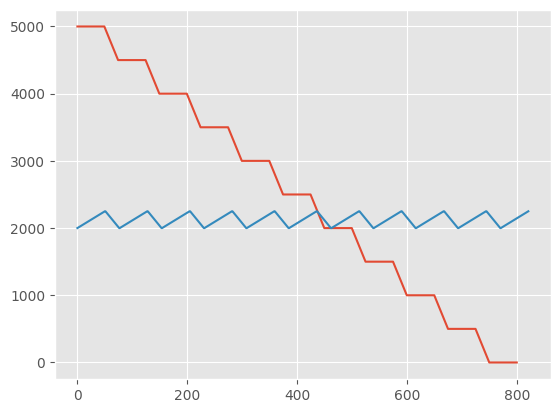

In [6]:
y_d0 = np.array(final_list_d0)
y_d1 = np.array(final_list_d1)
x_d0 = [i for i in range(len(y_d0))]
x_d1 = [i for i in range(len(y_d1))]
plt.plot(x_d0,y_d0)
plt.plot(x_d1,y_d1)

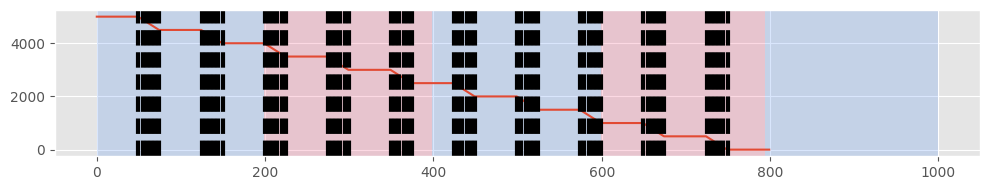

In [7]:
model = rpt.Pelt(model="l2")
model.fit(y_d0)

result = model.predict(pen=10)

# display
rpt.display(y_d0, bkps, result)
plt.show()

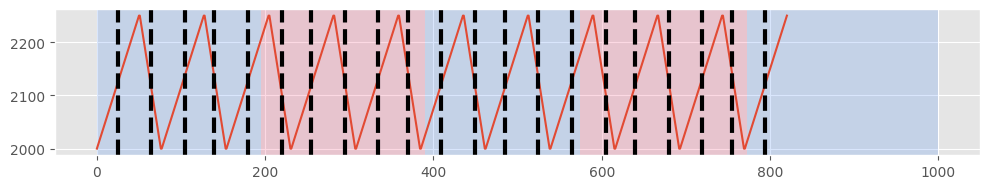

In [8]:
model = rpt.Pelt(model="rbf")
model.fit(y_d1)

result = model.predict(pen=10)

# display
rpt.display(y_d1, bkps, result)
plt.show()

## 2. PySpark monotony

In [9]:
!pip install pyspark

In [10]:
y_d0_ps = y_d0.reshape((len(y_d0),1))
y_d1_ps = y_d1.reshape((len(y_d1),1))

In [11]:
from pyspark.sql import SparkSession

# Because we aren't running on a spark cluster, the session is just for development
spark = SparkSession \
    .builder \
    .appName("PySpark Change Point Detection") \
    .getOrCreate()

In [12]:
from pyspark.sql.types import StructType, StructField, IntegerType

schema = StructType([ \
    StructField("dataset", IntegerType(), True)
  ])

dframe0 = spark.createDataFrame(data=y_d0_ps, schema=schema)
dframe1 = spark.createDataFrame(data=y_d1_ps, schema=schema)
dframe0.show(5)
dframe1.show(5)

+-------+
|dataset|
+-------+
|   5000|
|   5000|
|   5000|
|   5000|
|   5000|
+-------+
only showing top 5 rows

+-------+
|dataset|
+-------+
|   2000|
|   2005|
|   2010|
|   2015|
|   2020|
+-------+
only showing top 5 rows



In [36]:
from pyspark.sql.window import Window
from pyspark.sql.functions import struct, col
from pyspark.sql.functions import lag, lead

window = Window.partitionBy("dataset")
dframe0.withColumn("prev_value", lag(col("dataset"), 1).over(window)).show(5)
dframe0.withColumn("next_value", lead(col("dataset"), 1).over(window)).show(5)

AnalysisException: ignored

## 3. Pandas monotony

In [26]:
df_final = df_indexes_d0.reset_index(drop=True)
inicios = list(np.array(df_final.loc[df_final['index'].isin(indexes)].index.tolist())-1)

In [33]:
inicios_ = df_final.loc[inicios,'index'].tolist()

In [13]:
import pandas as pd

y_d0_ps = y_d0.reshape((len(y_d0),1))
y_d1_ps = y_d1.reshape((len(y_d1),1))

df_0 = pd.DataFrame(y_d0_ps,columns=['dataset'])
df_1 = pd.DataFrame(y_d1_ps,columns=['dataset'])

df_0['next'] = df_0['dataset'][1:].tolist() + [np.nan]
df_0['diff'] = df_0['next'] - df_0['dataset']
df_indexes_d0 = df_0[df_0['diff']<0]
df_indexes_d0['index'] = df_indexes_d0.index
df_indexes_d0['next_index'] = df_indexes_d0['index'][1:].tolist() + [np.nan]
df_indexes_d0['diff_index'] = df_indexes_d0['next_index'] - df_indexes_d0['index']
indexes = df_indexes_d0[df_indexes_d0['diff_index']>1].index.tolist()

<ipython-input-13-6f2355e6831b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d0['index'] = df_indexes_d0.index
<ipython-input-13-6f2355e6831b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d0['next_index'] = df_indexes_d0['index'][1:].tolist() + [np.nan]
<ipython-input-13-6f2355e6831b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

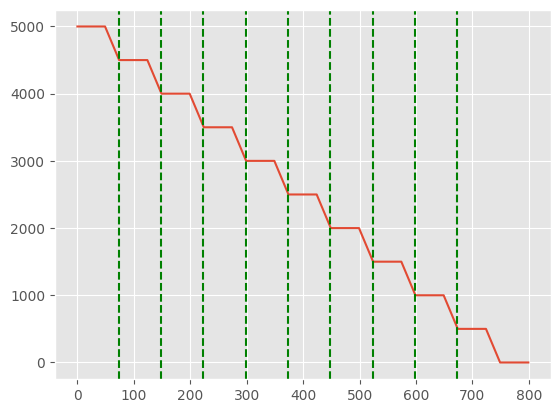

In [35]:
plt.plot(df_0.index,df_0['dataset'])
for index in indexes:
  plt.axvline(x = index, color = 'g', linestyle = '--')
plt.show()

In [59]:
import pandas as pd

y_d0_ps = y_d0.reshape((len(y_d0),1))
y_d1_ps = y_d1.reshape((len(y_d1),1))

df_0 = pd.DataFrame(y_d0_ps,columns=['dataset'])
df_1 = pd.DataFrame(y_d1_ps,columns=['dataset'])

df_1['next'] = df_1['dataset'][1:].tolist() + [np.nan]
df_1['diff'] = df_1['next'] - df_1['dataset']
df_indexes_d1 = df_1[df_1['diff']<0]
df_indexes_d1['index'] = df_indexes_d1.index
df_indexes_d1['next_index'] = df_indexes_d1['index'][1:].tolist() + [np.nan]
df_indexes_d1['diff_index'] = df_indexes_d1['next_index'] - df_indexes_d1['index']
indexes = df_indexes_d1[df_indexes_d1['diff_index']>1].index.tolist()

<ipython-input-59-808872cf356b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d1['index'] = df_indexes_d1.index
<ipython-input-59-808872cf356b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_indexes_d1['next_index'] = df_indexes_d1['index'][1:].tolist() + [np.nan]
<ipython-input-59-808872cf356b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

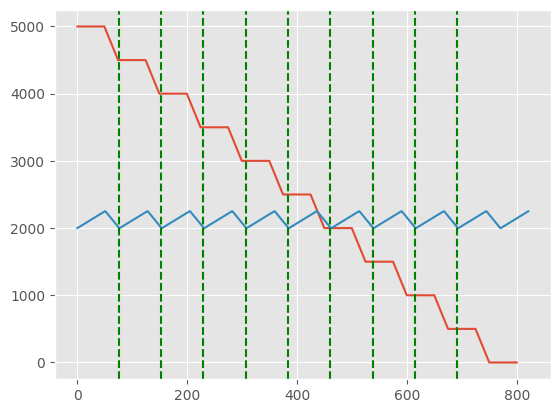

In [61]:
plt.plot(df_0.index,df_0['dataset'])
plt.plot(df_1.index,df_1['dataset'])
for index in indexes:
  plt.axvline(x = index, color = 'g', linestyle = '--')
plt.show()

## 1. Costs function

In [36]:
# Least absolute derivation (L1)
def l1_cost(signal, start, end):
  subset = signal[start:end]
  med = np.median(subset, axis=0)
  return abs(subset - med).sum()

# Least squared deviation (L2)
def l2_cost(signal, start, end):
  subset = signal[start:end]
  return subset.var(axis=0).sum()*(end - start)

## 2. Optimal changing point

In [37]:
def optimal_cp(signal, start, end):
        segment_cost = l2_cost(signal, start, end)
        if np.isinf(segment_cost) and segment_cost < 0:  # if cost is -inf
            return None, 0
        gain_list = list()
        for bkp in range(start, end, 5):
            if bkp - start >= 1 and end - bkp >= 1:
                gain = (
                    segment_cost - l2_cost(signal, start, bkp) - l2_cost(signal, bkp, end)
                )
                gain_list.append((gain, bkp))
        try:
            gain, bkp = max(gain_list)
        except ValueError:  # if empty sub_sampling
            return None, 0
        return gain_list, bkp, gain

In [38]:
y_ = np.array(np.repeat(100,50).tolist() + np.repeat(0,50).tolist())
x_ = range(len(y_))

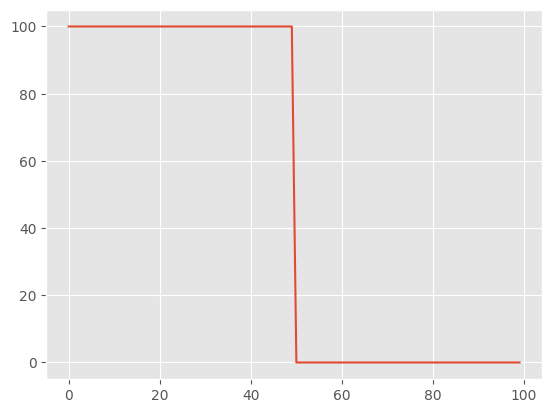

In [39]:
plt.plot(x_,y_)

In [40]:
rev = [i for i in range(30,50,4)]
rev.reverse()
y__ = np.array([i for i in range(50)] + rev + [i for i in range(30,80)])
x__ = np.array([i for i in range(len(y__))])

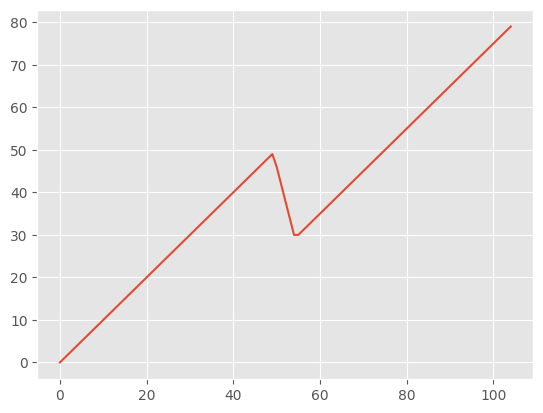

In [41]:
plt.plot(x__,y__)

In [44]:
gain_list, bkp, gain = optimal_cp(y__, 0, len(y__)-1)

In [45]:
max(gain_list[1:])

(25644.469760312153, 35)